# Crowd Counting by Basic CNN, VGG16 on Original/Thermal Images, and ResNet50

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shutil
import zipfile
import scipy as sc
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
import itertools
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import *
from tensorflow.keras.utils import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications import resnet50,vgg16
from tensorflow.keras import backend as K
from google.colab.patches import cv2_imshow
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
sns.set(style='white', context='notebook', palette='deep')

## 2. Data Preparation

### 2.1 Load and Review Dataset

In [ ]:
# Set the path to your dataset in Google Drive
dataset_path = "/content/drive/MyDrive/Colab Notebooks/FinalProject/DataSet/"

In [ ]:
# Load labels and images
labels_df = pd.read_csv(os.path.join(dataset_path, 'labels.csv'))
img_df = np.load(os.path.join(dataset_path, 'images.npy'))

In [ ]:
# Display some information about the dataset
print("Labels dataframe:")
display(labels_df.head())

Labels dataframe:


,id,count
0,1,35
1,2,41
2,3,41
3,4,44
4,5,41


In [ ]:
labels_df.describe()

,id,count
count,2000.000000,2000.000000
mean,1000.500000,31.157500
std,577.494589,6.945417
min,1.000000,13.000000
25%,500.750000,26.000000
50%,1000.500000,31.000000
75%,1500.250000,36.000000
max,2000.000000,53.000000


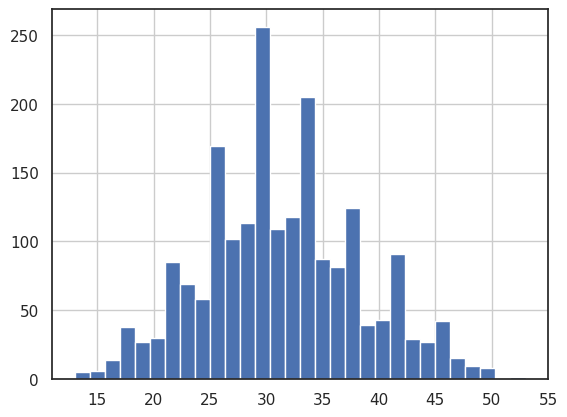

In [ ]:
labels_df['count'].hist(bins=30);

In [ ]:
# Map each id to its appropriate file name
labels_df['image_name'] = labels_df['id'].map('seq_{:06d}.jpg'.format)

In [ ]:
labels_df

,id,count,image_name
0,1,35,seq_000001.jpg
1,2,41,seq_000002.jpg
2,3,41,seq_000003.jpg
3,4,44,seq_000004.jpg
4,5,41,seq_000005.jpg
...,...,...,...
1995,1996,27,seq_001996.jpg
1996,1997,27,seq_001997.jpg
1997,1998,25,seq_001998.jpg
1998,1999,26,seq_001999.jpg



### 2.2 Data Generator with Augmentation


The data generator is part of the data preparation process for training a CNN for crowd counting, providing a flow of augmented image batches during the training phase. Data augmentation is used to artificially increase the size of our training dataset. The goal is to expose the model to a variety of transformed versions of the original data, helping the model generalize better to unseen data and improving its robustness.    
- By applying random transformations (such as flipping, rotation, zooming, etc.), the model sees different views of the same scene, making it more robust to variations in crowd density, perspective, and other factors.  
- The augmented data introduces additional complexity, making it less likely for the model to memorize specific training examples, thus mitigating overfitting.  
- The model is trained on a more diverse set of examples, allowing it to generalize better to real-world scenarios.

In [ ]:
# Set the image size, batch size, and thermal image size
img_size = (240, 320)
batch_size = 32
thermal_img_size = (240, 320)

In [ ]:
# Set image size, batch size, and create a data augmentation generator
print("Data Augmentation Generator:")
img_aug = ImageDataGenerator(
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode='nearest'
)

Data Augmentation Generator:


In [ ]:
# Create training and validation sets on thermal images
print("Creating a training set:")
train_set = img_aug.flow_from_dataframe(
    dataframe=labels_df,
    directory=os.path.join(dataset_path, 'frames', 'frames'),
    x_col="image_name",
    y_col="count",
    target_size=img_size,
    shuffle=True,
    batch_size=batch_size,
    class_mode="raw",
    subset="training",
)

Creating a training set:
Found 1600 validated image filenames.


In [ ]:
print("Creating a validation set:")
validation_set = img_aug.flow_from_dataframe(
    dataframe=labels_df,
    directory=os.path.join(dataset_path, 'frames', 'frames'),
    x_col="image_name",
    y_col="count",
    target_size=img_size,
    shuffle=True,
    batch_size=batch_size,
    class_mode="raw",
    subset="validation",
)

Creating a validation set:
Found 400 validated image filenames.


## 3.0 Models Creation and Training: CNN, VGG16, ResNet50

### 3.1 CNN Model

#### 3.1.1 CNN Model Creation

In [ ]:
# Create the custom CNN model
model1 = Sequential()
model1.add(Conv2D(64, (3, 3), input_shape=(img_size[0], img_size[1], 3), activation="relu"))
model1.add(MaxPool2D(pool_size=(2, 2)))
model1.add(Conv2D(128, (3, 3), activation="relu"))
model1.add(MaxPool2D(pool_size=(2, 2)))
model1.add(Conv2D(256, (3, 3), activation="relu"))
model1.add(MaxPool2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))
model1.add(Flatten())
model1.add(Dense(256, activation="relu"))
model1.add(Dropout(0.5))
model1.add(Dense(1, activation="linear"))

In [ ]:
# Display the model summary
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 238, 318, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 119, 159, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 157, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 58, 78, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 76, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 38, 256)       0

In [ ]:
# Compile the model
optimizer = optimizers.Adam(learning_rate=0.001)
model1.compile(
    optimizer=optimizer,
    loss="mean_squared_error",
    metrics=['mean_absolute_error', 'mean_squared_error']
)

In [ ]:
# Define model checkpoints and learning rate reduction
model_path = "/content/drive/MyDrive/Crowd_Counting_Model1.h5"
checkpoint1 = ModelCheckpoint(
    filepath=model_path,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True,
    verbose=1
)

In [ ]:
learning_rate_reduction1 = ReduceLROnPlateau(
    monitor='val_mean_squared_error',
    patience=3,
    verbose=1,
    factor=0.2,
    min_lr=0.000001
)

#### 3.1.2 CNN Model Training

In [ ]:
# Train the model
history1 = model1.fit_generator(
    generator=train_set,
    epochs=2,
    validation_data=validation_set,
    verbose=2,
    callbacks=[checkpoint1, learning_rate_reduction1],
)

Epoch 1/2

Epoch 1: val_mean_squared_error improved from inf to 48.40989, saving model to /content/drive/MyDrive/Crowd_Counting_Model1.h5
50/50 - 740s - loss: 178.1376 - mean_absolute_error: 10.0378 - mean_squared_error: 178.1376 - val_loss: 48.4099 - val_mean_absolute_error: 5.5469 - val_mean_squared_error: 48.4099 - lr: 0.0010 - 740s/epoch - 15s/step
Epoch 2/2

Epoch 2: val_mean_squared_error improved from 48.40989 to 45.46465, saving model to /content/drive/MyDrive/Crowd_Counting_Model1.h5
50/50 - 42s - loss: 65.1767 - mean_absolute_error: 6.4334 - mean_squared_error: 65.1767 - val_loss: 45.4646 - val_mean_absolute_error: 5.3695 - val_mean_squared_error: 45.4646 - lr: 0.0010 - 42s/epoch - 843ms/step


In [ ]:
# Save the model1 after training
model1.save('/content/drive/MyDrive/Colab Notebooks/FinalProject/model1.h5')
# Load the saved model1
# loaded_model1 = load_model('/content/drive/MyDrive/Colab Notebooks/FinalProject/model1.h5')

In [ ]:
# Display model information
print(f"The model1 is saved at: {model_path}")
print("Retrieving the trained model:")
model1 = load_model(model_path)
display(model1.summary())

The model1 is saved at: /content/drive/MyDrive/Crowd_Counting_Model1.h5
Retrieving the trained model:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 238, 318, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 119, 159, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 157, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 58, 78, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 76, 256)       295168    
                    

None

### 3.2 Pretrained VGG16 Model on Original Images


#### 3.2.1 Load Model

In [ ]:
model_path2a="Crowd_Counting_Model2a.h5"
checkpoint2a=ModelCheckpoint(
    filepath=model_path2a,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True,
    verbose=1
)
print("Model Checkpoint Created:")
print(checkpoint2a)
print()
print("Learning Rate Reduction:")
learning_rate_reduction2a = ReduceLROnPlateau(
    monitor='val_mean_squared_error',
    patience=3,
    verbose=1,
    factor=0.2,
    min_lr=0.000001
)
print(learning_rate_reduction2a)

Model Checkpoint Created:

Learning Rate Reduction:


In [ ]:
vgg16=VGG16(include_top=False,weights="imagenet",input_shape=(240,320,3),pooling="avg")
x = vgg16.output
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='linear')(x)
model2a=Model(inputs=vgg16.input, outputs=predictions)
k = -7
for layer in model2a.layers[:k]:
    layer.trainable = False
print('Trainable layers:')
for layer in model2a.layers[k:]:
    print(layer.name)
    layer.trainable = True
print()
display(model2a.summary())

58889256/58889256 [==============================] - 0s 0us/step
Trainable layers:
block5_conv1
block5_conv2
block5_conv3
block5_pool
global_average_pooling2d
dense_2
dense_3

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 320, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 320, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 160, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 160, 128)     73856     
                                                                 
 block2_conv2 (Co

None

Final Model-2a (VGG 16) Summary:


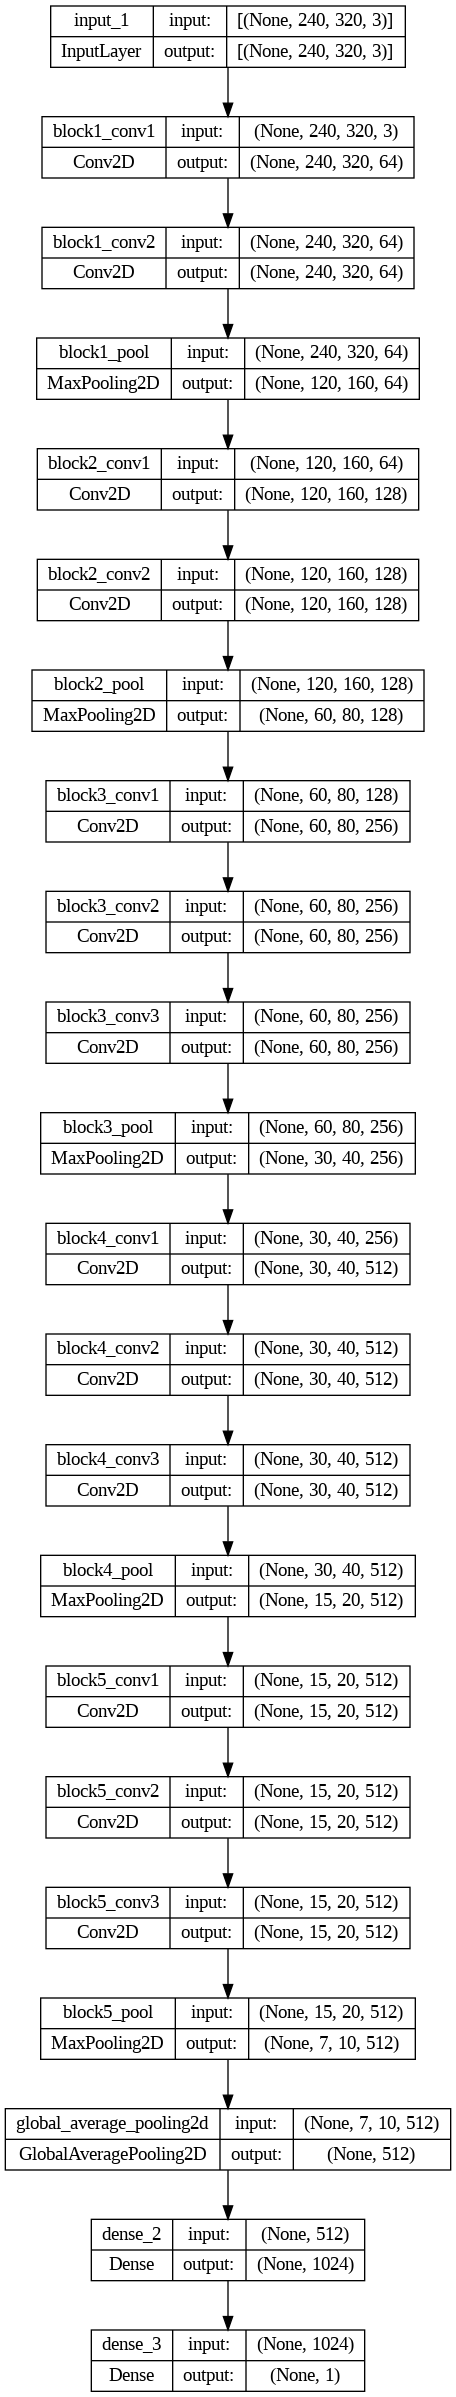

In [ ]:
# Display the model summary
print("Final Model-2a (VGG 16) Summary:")
plot_model(
    model2a,
    to_file="Crowd_Counting_Model2a.png",
    show_shapes=True,
)

#### 3.2.2 Model Training

In [ ]:
optimizer = Adam(learning_rate=0.001)
model2a.compile(
    optimizer=optimizer,
    loss="mean_squared_error",
    metrics=['mean_absolute_error', 'mean_squared_error']
)

In [ ]:
history2a = model2a.fit_generator(
    generator=train_set,
    epochs=2,
    validation_data=validation_set,
    verbose=2,
    callbacks=[checkpoint2a,learning_rate_reduction2a],
)
print('\nModel Training Finished.')

Epoch 1/2

Epoch 1: val_mean_squared_error improved from inf to 42.07563, saving model to Crowd_Counting_Model2a.h5
50/50 - 40s - loss: 1039.2450 - mean_absolute_error: 14.1430 - mean_squared_error: 1039.2450 - val_loss: 42.0756 - val_mean_absolute_error: 5.1547 - val_mean_squared_error: 42.0756 - lr: 0.0010 - 40s/epoch - 797ms/step
Epoch 2/2

Epoch 2: val_mean_squared_error improved from 42.07563 to 37.47728, saving model to Crowd_Counting_Model2a.h5
50/50 - 35s - loss: 40.2676 - mean_absolute_error: 5.0377 - mean_squared_error: 40.2676 - val_loss: 37.4773 - val_mean_absolute_error: 4.8730 - val_mean_squared_error: 37.4773 - lr: 0.0010 - 35s/epoch - 704ms/step

Model Training Finished.


In [ ]:
# Save the model2a after training
model2a.save('/content/drive/MyDrive/Colab Notebooks/FinalProject/model2a.h5')
# Load the saved model2a
# loaded_model2a = load_model('/content/drive/MyDrive/Colab Notebooks/FinalProject/model2a.h5')

### 3.3 Pretrained VGG16 Model on Thermal Images

#### 3.3.1 Create Thermal Images

In [ ]:
# Display information about the dataset
# print(f"Importing Input Image Dataset of shape {img_df.shape}.")
# print("Checking the Image Dataset:")
# display(img_df[0])

# Create thermal images to isolate the regions of interest
therm_img_df = []
for img in img_df:
    thermal_img = cv2.applyColorMap(img, cv2.COLORMAP_JET)
    therm_img_df.append(thermal_img)
therm_img_df = np.array(therm_img_df)

In [ ]:
# Display information about the dataset
print(f"Importing Input Image Dataset of shape {img_df.shape}.")
print("Checking the Image Dataset:")
display(img_df[0])

# Create thermal images to isolate the regions of interest
therm_img_df = []
for img in img_df:
    thermal_img = cv2.applyColorMap(img, cv2.COLORMAP_JET)
    therm_img_df.append(thermal_img)
therm_img_df = np.array(therm_img_df)

Importing Input Image Dataset of shape (2000, 480, 640, 3).
Checking the Image Dataset:


array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[150, 118,  95],
        [151, 119,  96],
        [151, 119,  96],
        ...,
        [201, 156, 115],
        [204, 159, 117],
        [205, 161, 116]],

       [[152, 120,  97],
        [152, 120,  97],
        [152, 120,  97],
        ...,
        [188, 143, 102],
        [191, 146, 104],
        [192, 148, 103]],

       [[152, 120,  97],
        [151, 119,  96],
        [151, 119,  96],
        ...,
        [178, 133,  92],
        [175, 130,  88],
        [172, 128,  83]]

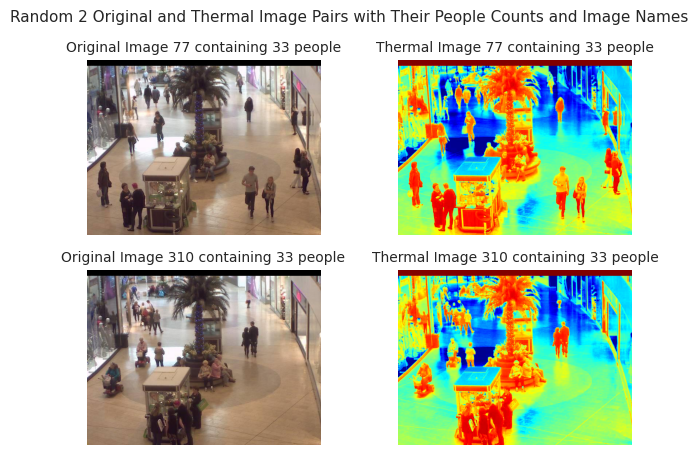

In [ ]:
# Display random pairs of original and thermal images
num_img_display = 2
fig, axes = plt.subplots(2, 2, figsize=(8, 5))

for i in range(num_img_display):
    rand_idx = np.random.randint(0, img_df.shape[0])
    img_label = labels_df.loc[rand_idx, "count"]

    ax_original = axes[i, 0]
    original_image = img_df[rand_idx]
    ax_original.imshow(original_image)
    ax_original.axis("off")
    ax_original.set_title(f"Original Image {rand_idx} containing {img_label} people", fontsize=10)

    ax_thermal = axes[i, 1]
    thermal_image = therm_img_df[rand_idx]
    ax_thermal.imshow(thermal_image)
    ax_thermal.axis("off")
    ax_thermal.set_title(f"Thermal Image {rand_idx} containing {img_label} people", fontsize=10)

plt.suptitle("Random 2 Original and Thermal Image Pairs with Their People Counts and Image Names", fontsize=11)
plt.subplots_adjust(wspace=0.01)
plt.show()

In [ ]:
# Save thermal images to a folder
input_folder = '/content/drive/MyDrive/Colab Notebooks/FinalProject/DataSet/frames/frames'
output_folder = '/content/drive/MyDrive/Colab Notebooks/FinalProject/DataSet/thermal_frames'
os.makedirs(output_folder, exist_ok=True)
image_files = os.listdir(input_folder)
for image_file in image_files:
    original_image = cv2.imread(os.path.join(input_folder, image_file))
    thermal_image = cv2.applyColorMap(original_image, cv2.COLORMAP_JET)
    cv2.imwrite(os.path.join(output_folder, image_file), thermal_image)
print(f"Thermal images saved in folder: {output_folder}")

Thermal images saved in folder: /content/drive/MyDrive/Colab Notebooks/FinalProject/DataSet/thermal_frames


In [ ]:
# zip_file_name = '/content/drive/MyDrive/Colab Notebooks/FinalProject/thermal_frames.zip'
# with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
#     for root, _, files in os.walk(output_folder):
#         for file in files:
#             zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), output_folder))
# print(f"Thermal images saved and zipped as '{zip_file_name}'")

In [ ]:
# Create training and validation sets on thermal images
print("Creating a training set on thermal images:")
train_set_therm=img_aug.flow_from_dataframe(
    dataframe=labels_df,
    directory='/content/drive/MyDrive/Colab Notebooks/FinalProject/DataSet/thermal_frames',
    x_col="image_name",
    y_col="count",
    target_size=img_size,
    shuffle=True,
    batch_size=batch_size,
    class_mode="raw",
    subset="training",
    )
print(train_set_therm)

Creating a training set on thermal images:
Found 1600 validated image filenames.


In [ ]:
print("Creating a validation set:")
valid_set_therm=img_aug.flow_from_dataframe(
    dataframe=labels_df,
    directory='/content/drive/MyDrive/Colab Notebooks/FinalProject/DataSet/thermal_frames',
    x_col="image_name",
    y_col="count",
    target_size=img_size,
    shuffle=True,
    batch_size=batch_size,
    class_mode="raw",
    subset="validation",
    )
print(valid_set_therm)

Creating a validation set:
Found 400 validated image filenames.


#### 3.3.2 Load Model

In [ ]:
model_path2b="Crowd_Counting_Model2b.h5"
checkpoint2b=ModelCheckpoint(
    filepath=model_path2b,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True,
    verbose=1
)
print("Model Checkpoint Created:")
print(checkpoint2b)
print()
print("Learning Rate Reduction:")
learning_rate_reduction2b = ReduceLROnPlateau(
    monitor='val_mean_squared_error',
    patience=3,
    verbose=1,
    factor=0.2,
    min_lr=0.000001
)
print(learning_rate_reduction2b)

Model Checkpoint Created:

Learning Rate Reduction:


In [ ]:
vgg16=VGG16(include_top=False,weights="imagenet",input_shape=(240,320,3),pooling="avg")
x = vgg16.output
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='linear')(x)
model2b=Model(inputs=vgg16.input, outputs=predictions)
k = -7
for layer in model2b.layers[:k]:
    layer.trainable = False
print('Trainable layers:')
for layer in model2b.layers[k:]:
    print(layer.name)
    layer.trainable = True
print()
display(model2b.summary())

Trainable layers:
block5_conv1
block5_conv2
block5_conv3
block5_pool
global_average_pooling2d_1
dense_4
dense_5

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 320, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 320, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 160, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 160, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 160, 128)     147584    
            

None

Final Model-2b Summary of VGG 16 on Thermal Images:


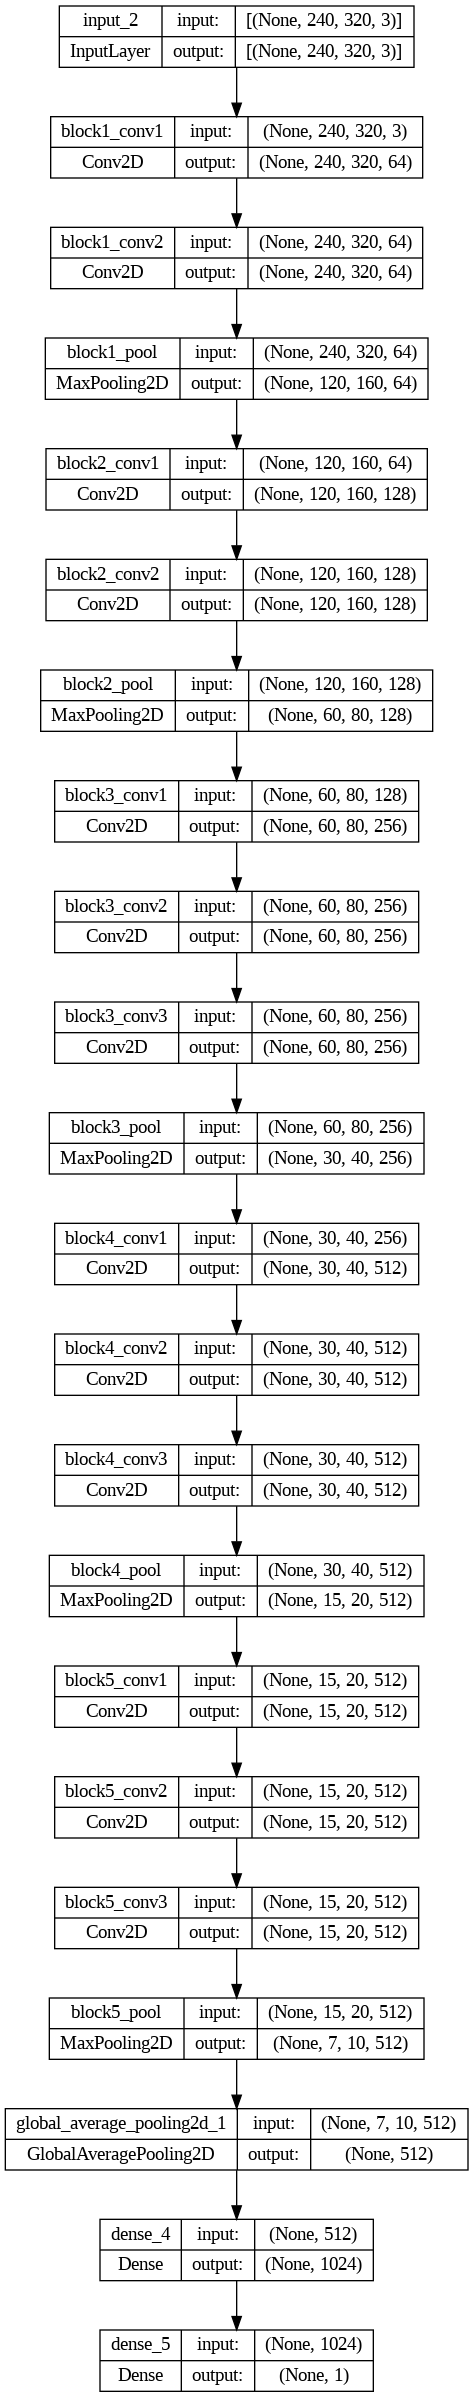

In [ ]:
# Display the model summary
print("Final Model-2b Summary of VGG 16 on Thermal Images:")
plot_model(
    model2b,
    to_file="Crowd_Counting_model2b.png",
    show_shapes=True,
)

#### 3.3.3 Model Training

In [ ]:
optimizer = Adam(learning_rate=0.001)
model2b.compile(
    optimizer=optimizer,
    loss="mean_squared_error",
    metrics=['mean_absolute_error', 'mean_squared_error']
)
history2b = model2b.fit_generator(
    generator=train_set_therm,
    epochs=2,
    validation_data=valid_set_therm,
    verbose=2,
    callbacks=[checkpoint2b,learning_rate_reduction2b],
)
print('\nModel Training Finished.')

Epoch 1/2

Epoch 1: val_mean_squared_error improved from inf to 43.32009, saving model to Crowd_Counting_Model2b.h5
50/50 - 39s - loss: 1651.2906 - mean_absolute_error: 15.0188 - mean_squared_error: 1651.2906 - val_loss: 43.3201 - val_mean_absolute_error: 5.1950 - val_mean_squared_error: 43.3201 - lr: 0.0010 - 39s/epoch - 786ms/step
Epoch 2/2

Epoch 2: val_mean_squared_error did not improve from 43.32009
50/50 - 38s - loss: 47.9143 - mean_absolute_error: 5.4836 - mean_squared_error: 47.9143 - val_loss: 44.3843 - val_mean_absolute_error: 5.2469 - val_mean_squared_error: 44.3843 - lr: 0.0010 - 38s/epoch - 758ms/step

Model Training Finished.


In [ ]:
# Save the model2b after training
model2b.save('/content/drive/MyDrive/Colab Notebooks/FinalProject/model2b.h5')
# Load the saved model2b
# loaded_model2b = load_model('/content/drive/MyDrive/Colab Notebooks/FinalProject/model2b.h5')

### 3.4 Pretrained ResNet50 Model

#### 3.4.1 Load Model

In [ ]:
base_model = resnet50.ResNet50(
    weights='imagenet',  # Load the pretrained weights, trained on the ImageNet dataset.
    include_top=False,  # We don't include the fully-connected layer at the top of the network - we need to modify the top.
    input_shape=(240, 320, 3),  # 240x320 was the original size ResNet was trained on, so I decided to use this.
    pooling='avg',  # A global average pooling layer will be added after the last convolutional block.
)

print()
display(base_model.summary())

94765736/94765736 [==============================] - 0s 0us/step

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 240, 320, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 246, 326, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 120, 160, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 120, 160, 64)         256       ['conv1_conv[0][0]']          
 on)                     

None

In [ ]:
# Here we change the top (the last parts) of the network.
x = base_model.output  # Since we used pooling='avg', the output is of the pooling layer
x = Dense(1024, activation='relu')(x)  # We add a single fully-connected layer
predictions = Dense(1, activation='linear')(x)  # This is the new output layer - notice only 1 output, this will correspond to the number of people in the image

In [ ]:
model3 = Model(inputs=base_model.input, outputs=predictions)

k = -7
for layer in model3.layers[:k]:
    layer.trainable = False
print('Trainable:')
for layer in model3.layers[k:]:
    print(layer.name)
    layer.trainable = True

Trainable:
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
avg_pool
dense_6
dense_7


In [ ]:
# Define the optimizer - this function will iteratively improve parameters in order to minimise the loss.
# The Adam optimization algorithm is an extension to stochastic gradient descent, which is usually more effective and fast.
optimizer = Adam(
    # The most important parameter is the learning rate - controls the amount that the weights are updated during eache round of training.
    learning_rate=0.001,
    # Additional parameters to play with:
#     beta_1=0.9,
#     beta_2=0.999,
#     epsilon=1e-07,
)

In [ ]:
# Compile the model
model3.compile(
    optimizer=optimizer,
    loss="mean_squared_error",  # This is a classic regression score - the lower the better
    metrics=['mean_absolute_error', 'mean_squared_error']
)

In [ ]:
# Set a learning rate annealer - to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.
# The LR is decreased dynamically when the score is not improved. This keeps the advantage of the fast computation time with a high LR at the start.
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_mean_squared_error',  # Track the score on the validation set
    patience=3,      # Number of epochs in which no improvement is seen.
    verbose=1,
    factor=0.2,      # Factor by which the LR is multiplied.
    min_lr=0.000001  # Don't go below this value for LR.
)

#### 3.4.2 Model Training

In [ ]:
# Fit the model
history3 = model3.fit_generator(
    generator=train_set,
    epochs=2,
    validation_data=validation_set,
    verbose=2,
    callbacks=[learning_rate_reduction],
)
print('\nDone.')

Epoch 1/2
50/50 - 41s - loss: 79.4901 - mean_absolute_error: 6.6058 - mean_squared_error: 79.4901 - val_loss: 1141.0500 - val_mean_absolute_error: 33.2275 - val_mean_squared_error: 1141.0500 - lr: 0.0010 - 41s/epoch - 815ms/step
Epoch 2/2
50/50 - 35s - loss: 38.3893 - mean_absolute_error: 4.9612 - mean_squared_error: 38.3893 - val_loss: 57.6566 - val_mean_absolute_error: 6.2048 - val_mean_squared_error: 57.6566 - lr: 0.0010 - 35s/epoch - 696ms/step

Done.


In [ ]:
# Save the model3 after training
model3.save('/content/drive/MyDrive/Colab Notebooks/FinalProject/model3.h5')

# Load the saved model3
# loaded_model3 = load_model('/content/drive/MyDrive/Colab Notebooks/FinalProject/model3.h5')

## 4.0 Models: Training Histories and Evaluation

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from IPython.display import display

def plot_training_history(ax, history, label):
    ax.plot(history.history['loss'], color='b', label=f"Training loss ({label})")
    ax.plot(history.history['val_loss'], color='r', label=f"Validation loss ({label})", axes=ax)
    ax.set_ylim(top=np.max(history.history['val_loss']) * 1.2, bottom=0)
    ax.set_xlabel("Epochs", fontsize=10)
    ax.set_ylabel("Loss", fontsize=10)
    ax.legend(loc='best', shadow=True, fontsize=10)
    ax.set_title("Plotting Epochs vs Loss", fontsize=12)

def evaluate_model(model, validation_set, label):
    MSE, MAE = model.evaluate(validation_set, batch_size=batch_size)[:-1]
    print(f"{label} - Mean Squared Error: {round(MSE, 2)}")
    print(f"{label} - Mean Absolute Error: {round(MAE, 2)}")

    validation_set.reset()
    all_labels = []
    all_pred = []
    for i in range(len(validation_set)):
        x = next(validation_set)
        pred_i = np.round(model.predict(x[0])[:, 0]).astype(int)
        labels_i = x[1]
        all_labels.append(labels_i)
        all_pred.append(pred_i)

    y_valid = np.concatenate(all_labels)
    y_pred = np.concatenate(all_pred)

    F_MSE = mean_squared_error(y_valid, y_pred)
    F_MAE = mean_absolute_error(y_valid, y_pred)
    R2 = r2_score(y_valid, y_pred)

    print(f'{label} - Final Mean Squared Error: {F_MSE:.2f}')
    print(f'{label} - Final Mean Absolute Error: {F_MAE:.2f}')
    print(f'{label} - R Squared Score: {R2:.2f}')

    pred_df = pd.DataFrame({"True values": y_valid, "Predicted values": y_pred})
    return pred_df

def plot_scatter(ax, pred_df, label):
    ax.scatter(pred_df['True values'], pred_df['Predicted values'], alpha=0.5, s=14)
    ax.grid(axis='both')
    add_one_to_one_correlation_line(ax)
    ax.set_title(f'{label} - Validation', fontsize=12)
    ax.set_xlabel("True Values", fontsize=10)
    ax.set_ylabel("Predicted Values", fontsize=10)

def add_one_to_one_correlation_line(ax, min_factor=1, max_factor=1, **plot_kwargs):
    lim_min, lim_max = pd.DataFrame([ax.get_ylim(), ax.get_xlim()]).agg({0: 'min', 1: 'max'})
    lim_min *= min_factor
    lim_max *= max_factor
    plot_kwargs_internal = dict(color='cyan', ls='--')
    plot_kwargs_internal.update(plot_kwargs)
    ax.plot([lim_min, lim_max], [lim_min, lim_max], **plot_kwargs_internal)
    ax.set_ylim([lim_min, lim_max])
    ax.set_xlim([lim_min, lim_max])

In [ ]:
pred_df1 = evaluate_model(model1, validation_set, "CNN")

13/13 [==============================] - 8s 558ms/step - loss: 45.6595 - mean_absolute_error: 5.3779 - mean_squared_error: 45.6595
CNN - Mean Squared Error: 45.66
CNN - Mean Absolute Error: 5.38
1/1 [==============================] - 0s 78ms/step
CNN - Final Mean Squared Error: 45.63
CNN - Final Mean Absolute Error: 5.35
CNN - R Squared Score: -0.00


In [ ]:
pred_df2a = evaluate_model(model2a, validation_set, "VGG16 - Original")

13/13 [==============================] - 7s 520ms/step - loss: 37.7211 - mean_absolute_error: 4.9426 - mean_squared_error: 37.7211
VGG16 - Original - Mean Squared Error: 37.72
VGG16 - Original - Mean Absolute Error: 4.94
1/1 [==============================] - 0s 158ms/step
VGG16 - Original - Final Mean Squared Error: 37.81
VGG16 - Original - Final Mean Absolute Error: 4.92
VGG16 - Original - R Squared Score: 0.17


In [ ]:
pred_df2b = evaluate_model(model2b, validation_set, "VGG16 - Thermal")

13/13 [==============================] - 7s 523ms/step - loss: 72.4370 - mean_absolute_error: 6.9806 - mean_squared_error: 72.4370
VGG16 - Thermal - Mean Squared Error: 72.44
VGG16 - Thermal - Mean Absolute Error: 6.98
1/1 [==============================] - 0s 153ms/step
VGG16 - Thermal - Final Mean Squared Error: 72.40
VGG16 - Thermal - Final Mean Absolute Error: 6.96
VGG16 - Thermal - R Squared Score: -0.59


In [ ]:
pred_df3 = evaluate_model(model3, validation_set, "ResNet50")

13/13 [==============================] - 7s 520ms/step - loss: 58.0561 - mean_absolute_error: 6.1987 - mean_squared_error: 58.0561
ResNet50 - Mean Squared Error: 58.06
ResNet50 - Mean Absolute Error: 6.2
1/1 [==============================] - 1s 1s/step
ResNet50 - Final Mean Squared Error: 57.86
ResNet50 - Final Mean Absolute Error: 6.15
ResNet50 - R Squared Score: -0.27


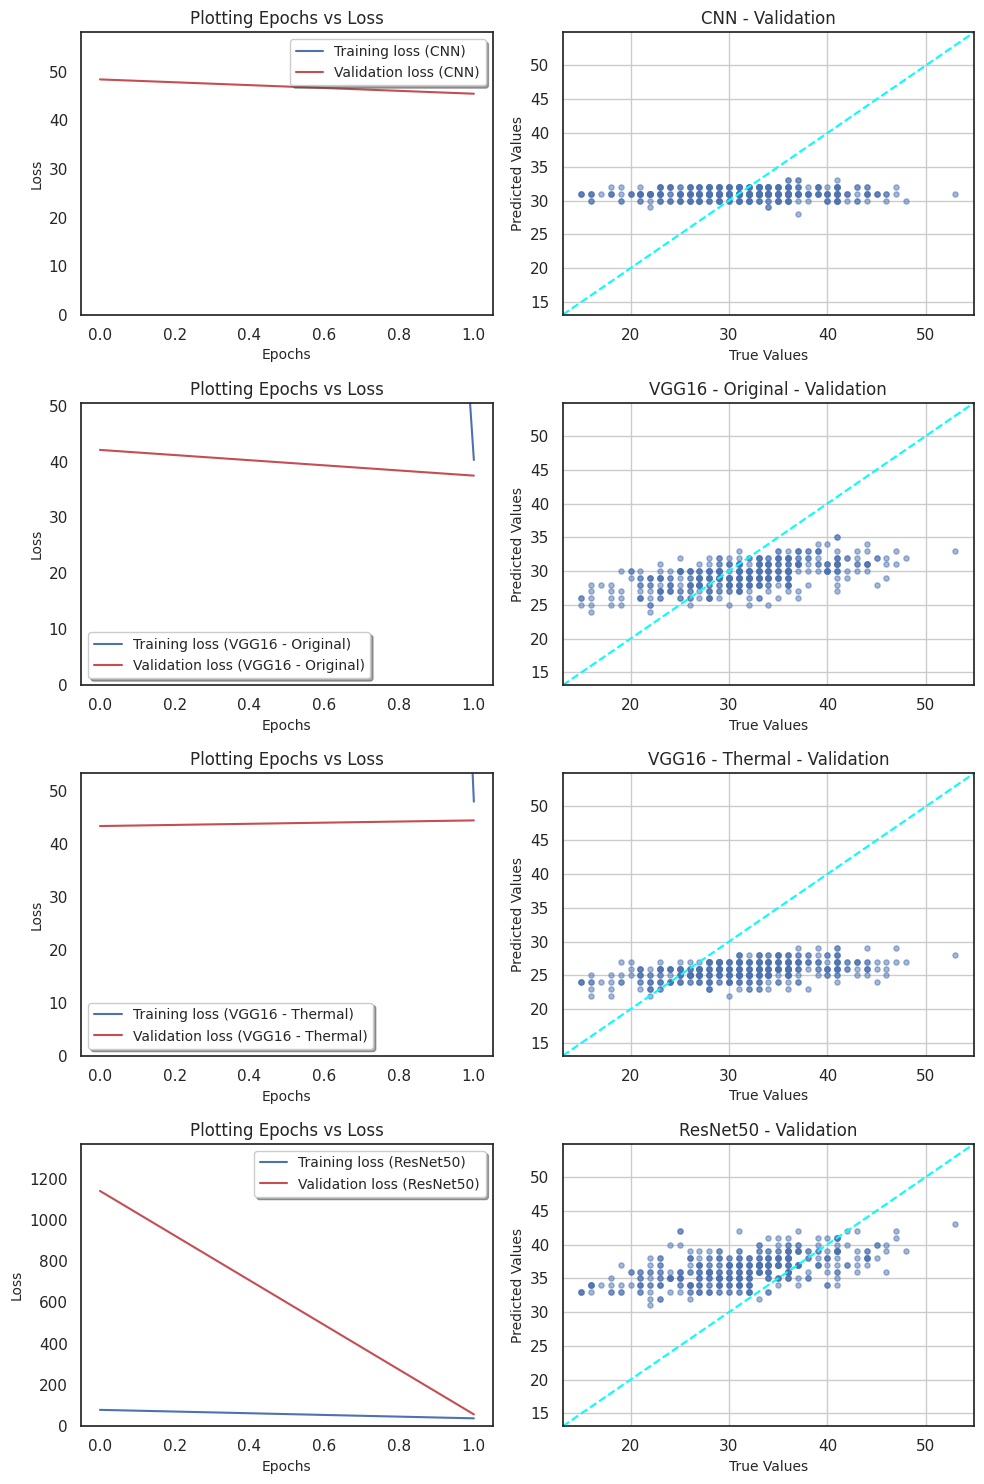

In [ ]:
# Create subplots
fig, axs = plt.subplots(4, 2, figsize=(10, 15))

# CNN, VGG16 History
plot_training_history(axs[0, 0], history1, "CNN")
plot_training_history(axs[1, 0], history2a, "VGG16 - Original")
plot_training_history(axs[2, 0], history2b, "VGG16 - Thermal")
plot_training_history(axs[3, 0], history3, "ResNet50")

# CNN, VGG16 Evaluation
plot_scatter(axs[0, 1], pred_df1, "CNN")
plot_scatter(axs[1, 1], pred_df2a, "VGG16 - Original")
plot_scatter(axs[2, 1], pred_df2b, "VGG16 - Thermal")
plot_scatter(axs[3, 1], pred_df3, "ResNet50")

plt.tight_layout()
plt.show()

## 5.0 Models Blind Predictions

In [ ]:
# from tensorflow.keras.models import load_model
import os

def predict_with_model(model, validation_set, img_name, dataset_path,model_name):
    print(f"Loading and ensuring the performance of the best {model_name} model:")
    # Load the model
    # model = load_model(model_path)

    # Load the image
    img_path = os.path.join(dataset_path, 'frames', 'frames', img_name)

    # Print the image filepath
    print(f"Image filepath: {img_path}")

    # Make predictions
    MSE, MAE = model.evaluate(validation_set, batch_size=batch_size)[:-1]

    print(f"{model_name} — Mean Squared Error:")
    print(round(MSE,2))
    print(f"{model_name} — Mean Absolute Error:")
    print(round(MAE,2))


    # Print the predictions
    # print(f"Predictions for {img_name}: {predictions}")

# Example usage for Model 1
# model1_path = '/content/drive/MyDrive/Colab Notebooks/FinalProject/model1.h5'
img_name = 'seq_000101.jpg'
dataset_path = '/content/drive/MyDrive/Colab Notebooks/FinalProject/DataSet/'
predict_with_model(model1, validation_set, img_name, dataset_path,"CNN")
predict_with_model(model2a, validation_set, img_name, dataset_path,"VGG16-Original")
predict_with_model(model2b, validation_set, img_name, dataset_path,"VGG16-Thermal")
predict_with_model(model3, validation_set, img_name, dataset_path,"ResNet50")

Loading and ensuring the performance of the best CNN model:
Image filepath: /content/drive/MyDrive/Colab Notebooks/FinalProject/DataSet/frames/frames/seq_000101.jpg
13/13 [==============================] - 7s 519ms/step - loss: 45.5096 - mean_absolute_error: 5.3749 - mean_squared_error: 45.5096
CNN — Mean Squared Error:
45.51
CNN — Mean Absolute Error:
5.37
Loading and ensuring the performance of the best VGG16-Original model:
Image filepath: /content/drive/MyDrive/Colab Notebooks/FinalProject/DataSet/frames/frames/seq_000101.jpg
13/13 [==============================] - 7s 528ms/step - loss: 37.5293 - mean_absolute_error: 4.8845 - mean_squared_error: 37.5293
VGG16-Original — Mean Squared Error:
37.53
VGG16-Original — Mean Absolute Error:
4.88
Loading and ensuring the performance of the best VGG16-Thermal model:
Image filepath: /content/drive/MyDrive/Colab Notebooks/FinalProject/DataSet/frames/frames/seq_000101.jpg
13/13 [==============================] - 7s 531ms/step - loss: 72.1749 -

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_and_visualize_subplot(model, image_path, labels_df, subplot_index, model_name):
    # Load the original image
    original_image = cv2.imread(image_path)
    original_image_count = labels_df.loc[102, "count"]

    # Resize the image to match the input size used during training
    img_size = (240, 320)
    resized_image = cv2.resize(original_image, img_size)

    # Normalize the image
    normalized_image = resized_image.astype('float32') / 255.0

    # Reshape the image to match the input shape expected by the model
    input_image = normalized_image.reshape((1, img_size[0], img_size[1], 3))

    # Make predictions using the specified model
    predicted_count = int(np.round(model.predict(input_image)[0, 0]))

    # Plot the image in the specified subplot
    plt.subplot(2, 2, subplot_index)
    plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Original: {original_image_count}\nPredicted (by {model_name}): {predicted_count}")
    plt.axis("off")

1/1 [==============================] - 0s 31ms/step


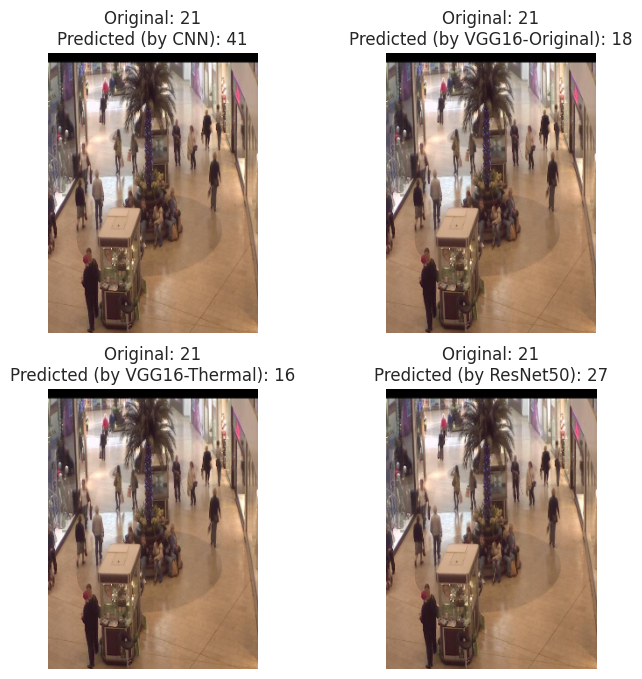

In [ ]:
# Prediction on some image that we randomly selected (seq_000101.jpg)
img_name="seq_000101.jpg"
original_image_path =dataset_path+ "frames/" + "frames/" + img_name

# Create a 2x2 subplot grid
plt.figure(figsize=(8, 8))

# Call the function for each model
predict_and_visualize_subplot(model1, original_image_path, labels_df, 1, "CNN")
predict_and_visualize_subplot(model2a, original_image_path, labels_df, 2, "VGG16-Original")
predict_and_visualize_subplot(model2b, original_image_path, labels_df, 3, "VGG16-Thermal")
predict_and_visualize_subplot(model3, original_image_path, labels_df, 4, "ResNet50")

plt.show()